# 1. Setup

In [0]:
!nvidia-smi

Mon Jul 29 12:39:43 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from google.colab import drive
drive.mount('/content/googledrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/googledrive


In [0]:
from fastai.vision import *
from fastai.vision.interpret import SegmentationInterpretation
from pathlib import Path

# 2. Dataset

## 2.1 Mount Drive and Setup Paths

In [0]:
!wget -O unet_dataset.zip https://files.slack.com/files-pri/TJRDXSH3L-FLNJR5F5F/download/unet_all_segmentation_masks.zip?pub_secret=4b11c19032

--2019-07-30 08:00:28--  https://files.slack.com/files-pri/TJRDXSH3L-FLNJR5F5F/download/unet_all_segmentation_masks.zip?pub_secret=4b11c19032
Resolving files.slack.com (files.slack.com)... 54.192.74.69
Connecting to files.slack.com (files.slack.com)|54.192.74.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27394092 (26M) [application/zip]
Saving to: ‘unet_dataset.zip’

unet_dataset.zip    100%[===================>]  26.12M  21.8MB/s    in 1.2s    

2019-07-30 08:00:30 (21.8 MB/s) - ‘unet_dataset.zip’ saved [27394092/27394092]



In [0]:
!unzip -qq unet_dataset.zip 

In [0]:
!ls 

data				     ESP_048293_2040_RED.NOMAP.thumb.jpg
drive				     googledrive
ESP_045168_2045_RED.LBL		     models
ESP_045168_2045_RED.NOMAP.thumb.jpg  results
ESP_046302_2025_RED.LBL		     tmp
ESP_046302_2025_RED.NOMAP.thumb.jpg  trained_unet.pkl
ESP_048293_2040_RED.LBL		     unet_dataset.zip


In [0]:
path = Path('drive/My Drive/Mars-Omdena/Unet_Segmentation_Dataset_Train')

In [0]:
path.ls()

[PosixPath('drive/My Drive/Mars-Omdena/Unet_Segmentation_Dataset_Train/SegmentationClassVisualization'),
 PosixPath('drive/My Drive/Mars-Omdena/Unet_Segmentation_Dataset_Train/SegmentationClassPNG'),
 PosixPath('drive/My Drive/Mars-Omdena/Unet_Segmentation_Dataset_Train/JPEGImages'),
 PosixPath('drive/My Drive/Mars-Omdena/Unet_Segmentation_Dataset_Train/class_names.txt'),
 PosixPath('drive/My Drive/Mars-Omdena/Unet_Segmentation_Dataset_Train/valid.txt'),
 PosixPath('drive/My Drive/Mars-Omdena/Unet_Segmentation_Dataset_Train/SegmentationClass')]

In [0]:
path_img = path/'JPEGImages'
path_lbl = path/'SegmentationClassPNG'
fnames = get_image_files(path_img)
lbl_names = get_image_files(path_lbl)

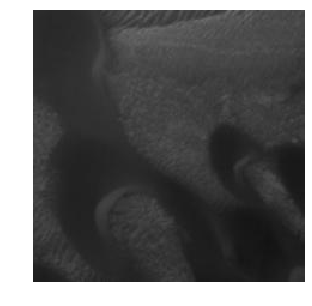

In [0]:
img_f = fnames[900]
img = open_image(img_f)
img.show(figsize=(5, 5))

In [0]:
get_y_fn = lambda x : path_lbl/f'{x.stem}.png'
get_y_fn(img_f)

PosixPath('drive/My Drive/Mars-Omdena/Unet_Segmentation_Dataset_Train/SegmentationClassPNG/ESP_018720_2655_RED-0043-fv.png')

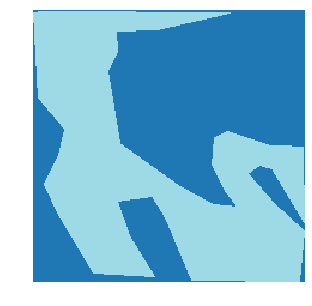

In [0]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5, 5), alpha=1)

In [0]:
with open(path/'class_names.txt') as f:
  codes = np.array([line.strip() for line in f.readlines()])
codes

array(['_background_', 'Crater', 'Dark Dune', 'Slope Streak', 'Bright Dune', 'Impact Ejecta', 'Swiss Cheese', 'Spider',
       'Technosignature'], dtype='<U15')

In [0]:
import matplotlib.image as mpimg
mpimg.imread(str(path/'JPEGImages/ESP_011289_1950_RED-0009-brt.jpg')).shape

(227, 227)

In [0]:
mask.shape

torch.Size([1, 227, 227])

In [0]:
src_size = np.array(mask.shape[1:])
size = 224 # src_size # src_size // 2
bs = 32

In [0]:
size, bs

(224, 32)

## 2.3 Initialize DataBunch

In [0]:
import PIL

In [0]:
get_y_fn = lambda x : path_lbl/f'{x.stem}.png'

In [0]:
path_lbl_npy = path/'SegmentationClass'

In [0]:
dir_name = Path('SegmentationLabels')
if not os.path.exists(dir_name):
    os.mkdir(dir_name)
    
def get_segmentation_label_fn(img_f):  
  label_imgname = dir_name/f'{img_f.stem}.png'
  if os.path.exists(label_imgname):
    return label_imgname
  
  npy_filename = path_lbl_npy/f'{img_f.stem}.npy'
  img = PIL.Image.fromarray(np.load(npy_filename))  
  img.save(label_imgname)
  return label_imgname

In [0]:
!ls

data				     googledrive
drive				     models
ESP_045168_2045_RED.LBL		     results
ESP_045168_2045_RED.NOMAP.thumb.jpg  SegmentationLabels
ESP_046302_2025_RED.LBL		     tmp
ESP_046302_2025_RED.NOMAP.thumb.jpg  trained_unet.pkl
ESP_048293_2040_RED.LBL		     unet_dataset.zip
ESP_048293_2040_RED.NOMAP.thumb.jpg


In [0]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_segmentation_label_fn, classes=codes)
      )

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
       .databunch(bs=bs)
       .normalize(imagenet_stats)
       )

CPU times: user 2.44 s, sys: 1.2 s, total: 3.64 s
Wall time: 7.35 s


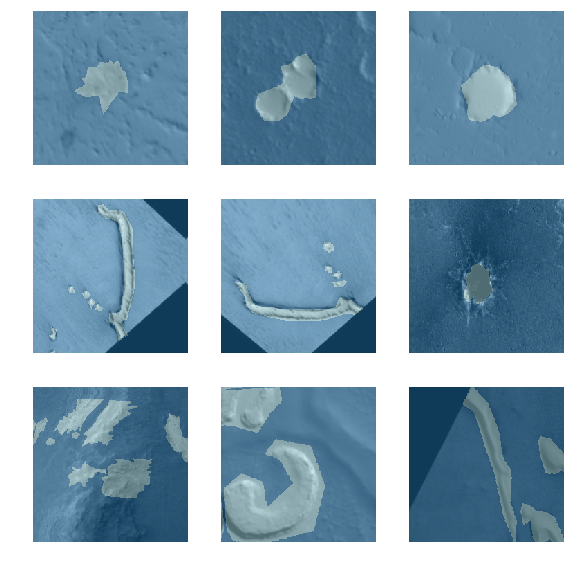

In [0]:
%%time
data.show_batch(rows=3, figsize=(8, 8))

In [0]:
name2id = {v:k for k, v in enumerate(codes)}
void_code = name2id['_background_']
void_code

0

# 3. Model

In [0]:
def acc_camvid(input, target):
  target = target.squeeze(1)
  mask = target != void_code
  return (input.argmax(dim=1)[mask] == target[mask]).float().mean()

In [0]:
learn = load_learner('googledrive/My Drive/Mars-Omdena/Official Folder Mars Omdena', 'techno_unet_689083.pkl')

## lr=8e-4

In [0]:
learn = unet_learner(data, models.resnet18, metrics=acc_camvid, wd=1e-2)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 51933635.41it/s]


In [0]:
learn.save('b4')

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


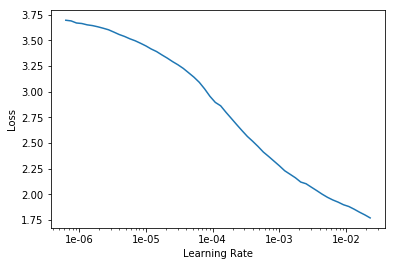

In [0]:
learn.recorder.plot()

In [0]:
learn.load('b4')
lr = 1e-3
learn.fit_one_cycle(10, lr, pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.071474,0.649935,0.003512,02:37
1,0.699444,0.489458,0.259027,02:30
2,0.533511,0.419011,0.307123,02:30
3,0.454216,0.342134,0.427634,02:30
4,0.407388,0.320534,0.429566,02:30
5,0.370627,0.306675,0.474722,02:30
6,0.334563,0.278027,0.526276,02:30
7,0.310581,0.258877,0.460976,02:29
8,0.278301,0.239633,0.611858,02:29
9,0.249707,0.207211,0.614177,02:29


In [0]:
learn.save('unet_614177')

In [0]:
learn.path

PosixPath('drive/My Drive/Mars-Omdena/Unet_Segmentation_Dataset_Train/JPEGImages')

In [0]:
!ls -l 'drive/My Drive/Mars-Omdena/Unet_Segmentation_Dataset_Train/JPEGImages/models'

total 520720
-rw-r--r-- 1 root root 124536597 Jul 29 16:29 b4.pth
-rw-r--r-- 1 root root 124536579 Jul 29 16:29 tmp.pth
-rw-r--r-- 1 root root 284135491 Jul 29 16:59 unet_614177.pth


In [0]:
!cp 'drive/My Drive/Mars-Omdena/Unet_Segmentation_Dataset_Train/JPEGImages/models/unet_614177.pth' 'googledrive/My Drive/Mars-Omdena/Official Folder Mars Omdena/techno_unet_614177.pth'

In [0]:
#learn.load('b4')
lr = 1e-4
learn.fit_one_cycle(10, lr, pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.200497,0.202260,0.647013,02:28
1,0.197965,0.199633,0.671531,02:29
2,0.193987,0.196609,0.694329,02:29
3,0.191342,0.191994,0.682048,02:28
4,0.185830,0.187556,0.692508,02:28
5,0.181843,0.194174,0.626596,02:29
6,0.178926,0.179885,0.700608,02:28
7,0.174157,0.192636,0.636091,02:28
8,0.171632,0.178950,0.653839,02:29
9,0.166775,0.176653,0.707929,02:29


In [0]:
learn.save('techno_unet_707929')

In [0]:
!cp 'drive/My Drive/Mars-Omdena/Unet_Segmentation_Dataset_Train/JPEGImages/models/techno_unet_707929.pth' 'googledrive/My Drive/Mars-Omdena/Official Folder Mars Omdena/techno_unet_707929.pth'

In [0]:
learn.save('mars_e4_10')

In [0]:
learn.load('mars_e4_10')

Learner(data=ImageDataBunch;

Train: LabelList (1387 items)
x: SegmentationItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: SegmentationLabelList
ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224)
Path: drive/My Drive/Mars-Omdena/Unet_Segmentation_Dataset_Train/JPEGImages;

Valid: LabelList (287 items)
x: SegmentationItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: SegmentationLabelList
ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224)
Path: drive/My Drive/Mars-Omdena/Unet_Segmentation_Dataset_Train/JPEGImages;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


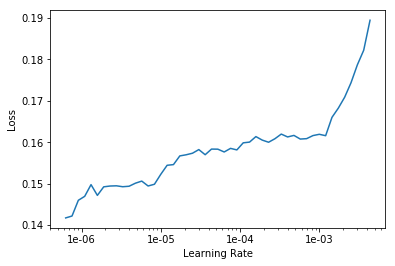

In [0]:
#learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


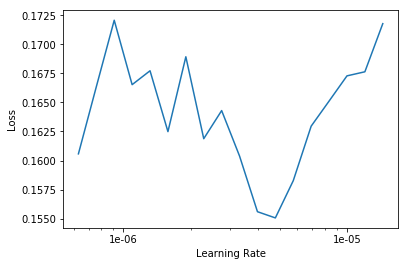

In [0]:
#learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 7e-7
learn.fit_one_cycle(5, lr, pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.156644,0.177093,0.703393,02:29
1,0.157215,0.176837,0.706006,02:29
2,0.156628,0.176294,0.705660,02:29
3,0.156219,0.174233,0.703773,02:29
4,0.157270,0.174283,0.700510,02:29


In [0]:
learn.save('techno_unet_700510')

In [0]:
!cp 'drive/My Drive/Mars-Omdena/Unet_Segmentation_Dataset_Train/JPEGImages/models/techno_unet_700510.pth' 'googledrive/My Drive/Mars-Omdena/Official Folder Mars Omdena/techno_unet_700510.pth'

In [0]:
lr = 3e-6
learn.fit_one_cycle(5, lr, pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.155031,0.174361,0.710551,02:29
1,0.156398,0.174585,0.699548,02:29
2,0.156066,0.174303,0.699637,02:29
3,0.155484,0.171959,0.706387,02:29
4,0.156358,0.172514,0.697715,02:28


In [0]:
learn.fit_one_cycle(5, lr, pct_start=0.9,wd=0.2)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.177063,0.204351,0.736073,01:08
1,0.187981,0.201598,0.724731,01:08
2,0.183509,0.198310,0.732865,01:09
3,0.170418,0.200684,0.733835,01:09
4,0.188351,0.202358,0.726202,01:09


In [0]:
learn.save('e4_10+5+5')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


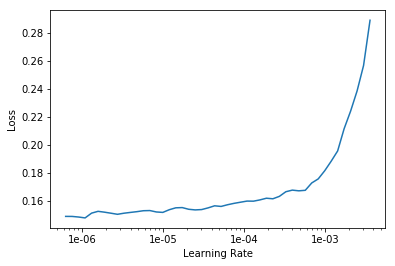

In [0]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(12, slice(1e-5,1e-4), pct_start=0.9,wd=0.15)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.155394,0.172956,0.717696,02:31
1,0.155878,0.171470,0.715369,02:31
2,0.154985,0.171908,0.740454,02:32
3,0.154894,0.168509,0.747861,02:31
4,0.154272,0.168855,0.701241,02:31
5,0.152668,0.166308,0.716301,02:31
6,0.151267,0.175443,0.726396,02:31
7,0.148853,0.168580,0.738591,02:31
8,0.148814,0.176136,0.657398,02:31
9,0.146431,0.168446,0.741177,02:31


In [0]:
learn.save('techno_unet_771086')

In [0]:
!cp 'drive/My Drive/Mars-Omdena/Unet_Segmentation_Dataset_Train/JPEGImages/models/techno_unet_771086.pth' 'googledrive/My Drive/Mars-Omdena/Official Folder Mars Omdena/techno_unet_771086.pth'

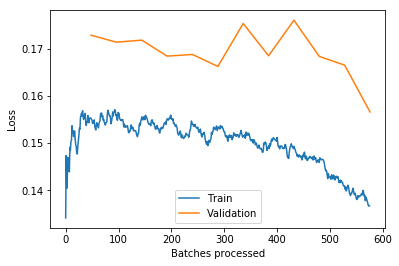

In [0]:
learn.recorder.plot_losses()

In [0]:
learn.freeze_to(-3)
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


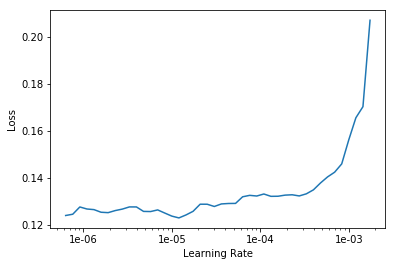

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5, slice(7e-06,7e-05),wd=0.1)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.135642,0.166034,0.740685,02:31
1,0.135677,0.174490,0.717633,02:31
2,0.134125,0.164167,0.746906,02:31
3,0.129440,0.160346,0.753179,02:31
4,0.125904,0.159030,0.757783,02:31


In [0]:
learn.fit_one_cycle(5, slice(7e-06,7e-05),wd=0.1)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.125342,0.166660,0.722930,02:31
1,0.123065,0.164561,0.762687,02:31
2,0.123934,0.161119,0.770243,02:31
3,0.121029,0.165028,0.738768,02:31
4,0.117348,0.160344,0.761856,02:31


In [0]:
learn.save('techno_unet_761856')

In [0]:
!cp 'drive/My Drive/Mars-Omdena/Unet_Segmentation_Dataset_Train/JPEGImages/models/techno_unet_761856.pth' 'googledrive/My Drive/Mars-Omdena/Official Folder Mars Omdena/techno_unet_761856.pth'

In [0]:
learn.load('techno_unet_771086')

Learner(data=ImageDataBunch;

Train: LabelList (1542 items)
x: SegmentationItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: SegmentationLabelList
ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224)
Path: drive/My Drive/Mars-Omdena/Unet_Segmentation_Dataset_Train/JPEGImages;

Valid: LabelList (332 items)
x: SegmentationItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: SegmentationLabelList
ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224)
Path: drive/My Drive/Mars-Omdena/Unet_Segmentation_Dataset_Train/JPEGImages;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(

In [0]:
learn.export('techno_unet_771086_lite.pkl')

In [0]:
!cp 'drive/My Drive/Mars-Omdena/Unet_Segmentation_Dataset_Train/JPEGImages/techno_unet_771086_lite.pkl' 'googledrive/My Drive/Mars-Omdena/Official Folder Mars Omdena/techno_unet_771086.pkl'

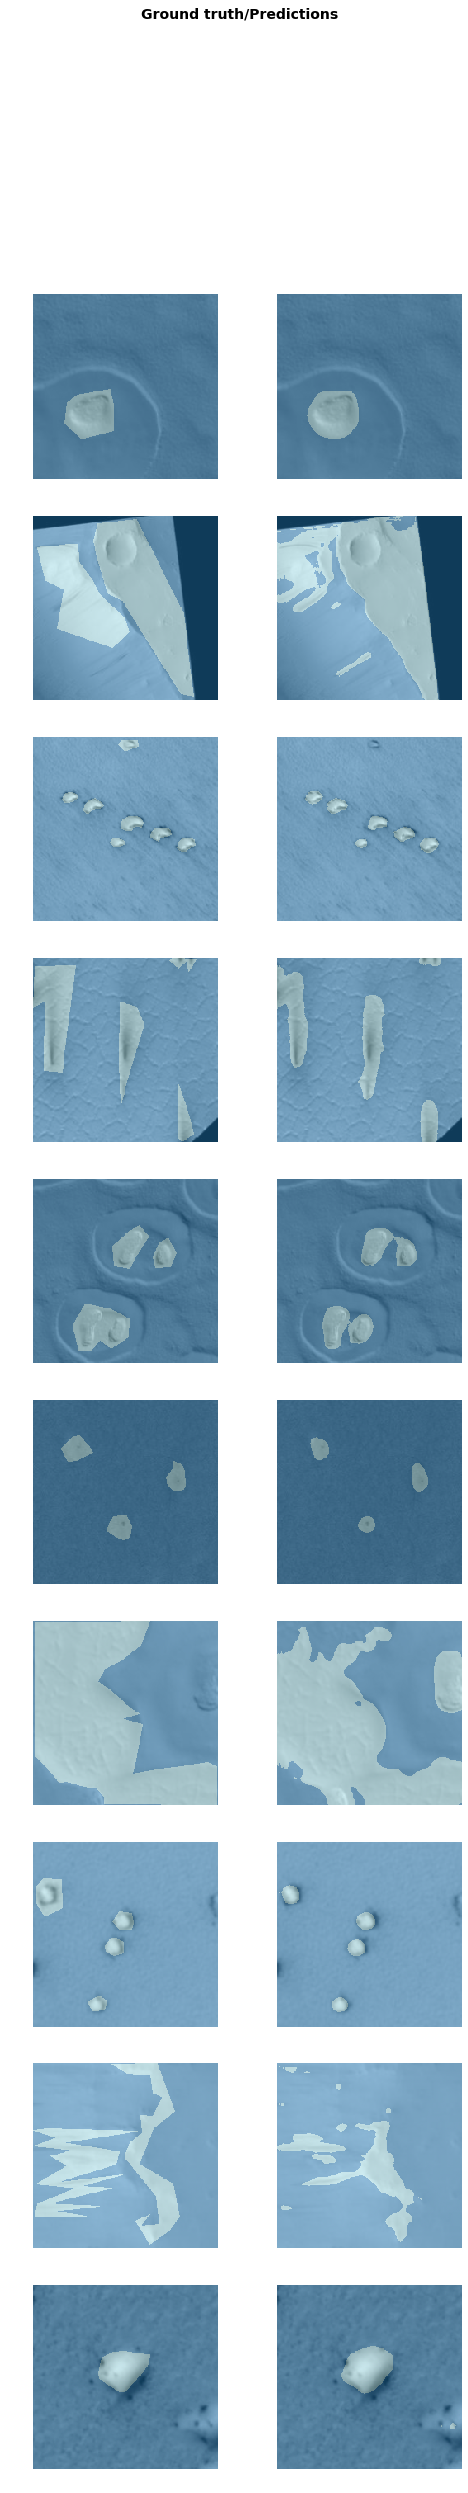

In [0]:
learn.show_results(rows=10) # show results

In [0]:
learn.fit_one_cycle(4,slice(1e-5,1e-4),pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.122972,0.161832,0.752261,02:31
1,0.125408,0.161586,0.739214,02:31
2,0.125226,0.171034,0.756646,02:31
3,0.130262,0.160051,0.763188,02:31


In [0]:
learn.save('ft12+4_mars_8e4_15')

# 4. Evaluation

In [0]:
!mkdir 'drive/My Drive/Mars-Omdena/Unet_Segmentation_Dataset_Train/JPEGImages/models'

In [0]:
!cp 'googledrive/My Drive/Mars-Omdena/Official Folder Mars Omdena/techno_unet_771086.pth' 'drive/My Drive/Mars-Omdena/Unet_Segmentation_Dataset_Train/JPEGImages/models/techno_unet_771086.pth'

In [0]:
learn.load('techno_unet_771086')

Learner(data=ImageDataBunch;

Train: LabelList (1542 items)
x: SegmentationItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: SegmentationLabelList
ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224)
Path: drive/My Drive/Mars-Omdena/Unet_Segmentation_Dataset_Train/JPEGImages;

Valid: LabelList (332 items)
x: SegmentationItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: SegmentationLabelList
ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224)
Path: drive/My Drive/Mars-Omdena/Unet_Segmentation_Dataset_Train/JPEGImages;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(

In [0]:
interp = SegmentationInterpretation.from_learner(learn)

In [0]:
top_losses, top_idxs = interp.top_losses(sizes=(224,224))

(array([235.,  65.,  19.,   6.,   2.,   2.,   1.,   0.,   1.,   1.]),
 array([0.007588, 0.172386, 0.337185, 0.501983, 0.666781, 0.831579, 0.996377, 1.161175, 1.325974, 1.490772, 1.65557 ],
       dtype=float32),
 <a list of 10 Patch objects>)

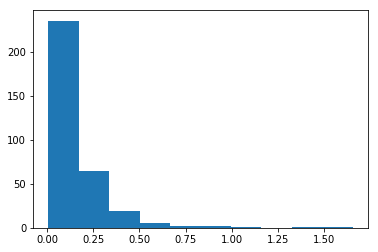

In [0]:
plt.hist(top_losses)

In [0]:
mean_cm, single_img_cm = interp._generate_confusion()

label,score
_background_,0.957138
Dark Dune,0.918169
Crater,0.90457
Swiss Cheese,0.853806
Bright Dune,0.837007
Impact Ejecta,0.73254
Spider,0.675749
Slope Streak,0.643795
Technosignature,0.307928


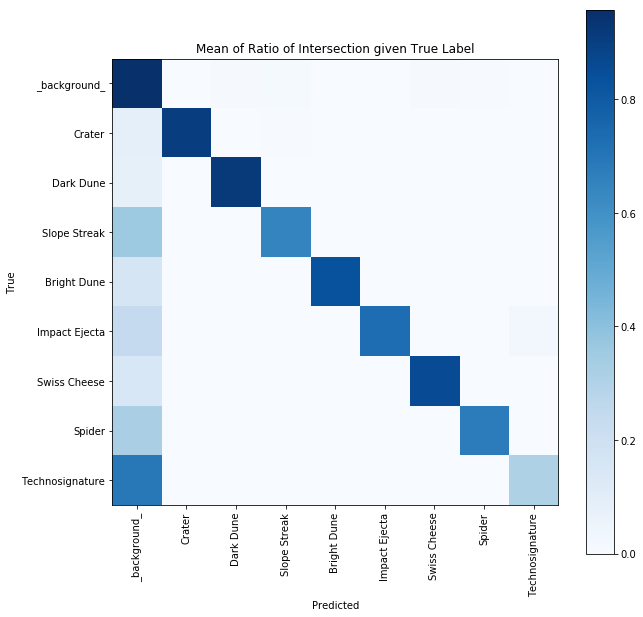

In [0]:
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")

In [0]:
mean_cm.shape

(9, 9)

In [0]:
import numpy as np
cm = mean_cm
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)
f1_score = 2 * (recall * precision) / (recall + precision)
recall, precision, f1_score

(array([0.957138, 0.90457 , 0.918169, 0.643795, 0.837007, 0.73254 , 0.853806, 0.675749, 0.307928], dtype=float32),
 array([0.313664, 0.9986  , 0.989208, 0.97403 , 0.998016, 0.99656 , 0.99105 , 0.989948, 0.917352], dtype=float32),
 array([0.472488, 0.949262, 0.952366, 0.775208, 0.910448, 0.844393, 0.917323, 0.803215, 0.461084], dtype=float32))

In [0]:
import pandas as pd
pd.DataFrame.from_dict({
    'Class': learn.data.classes,
    'Recall': recall,
    'Precision': precision,
    'F1-score': f1_score
}).iloc[1:]

,Class,Recall,Precision,F1-score
1,Crater,0.904570,0.998600,0.949262
2,Dark Dune,0.918169,0.989208,0.952366
3,Slope Streak,0.643795,0.974030,0.775208
4,Bright Dune,0.837007,0.998016,0.910448
5,Impact Ejecta,0.732540,0.996560,0.844393
6,Swiss Cheese,0.853806,0.991050,0.917323
7,Spider,0.675749,0.989948,0.803215
8,Technosignature,0.307928,0.917352,0.461084


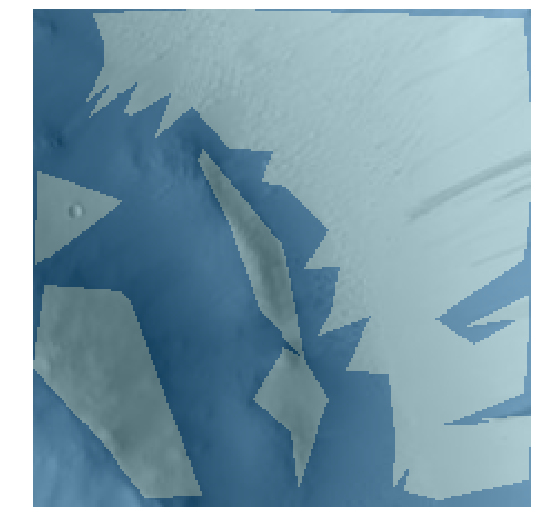

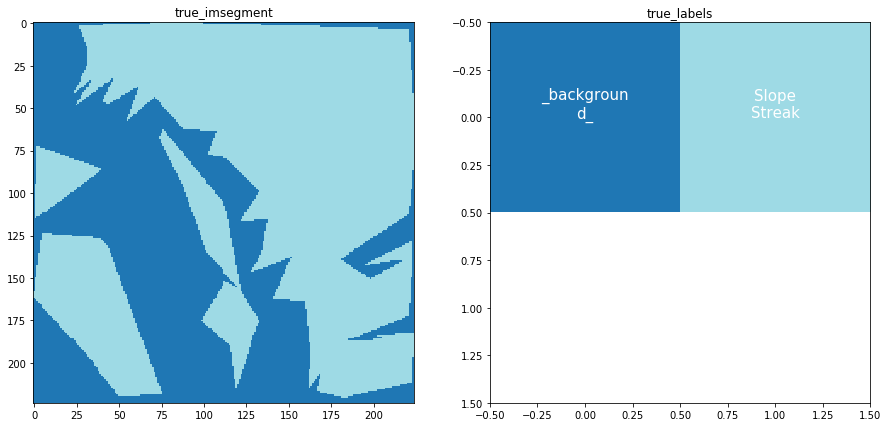

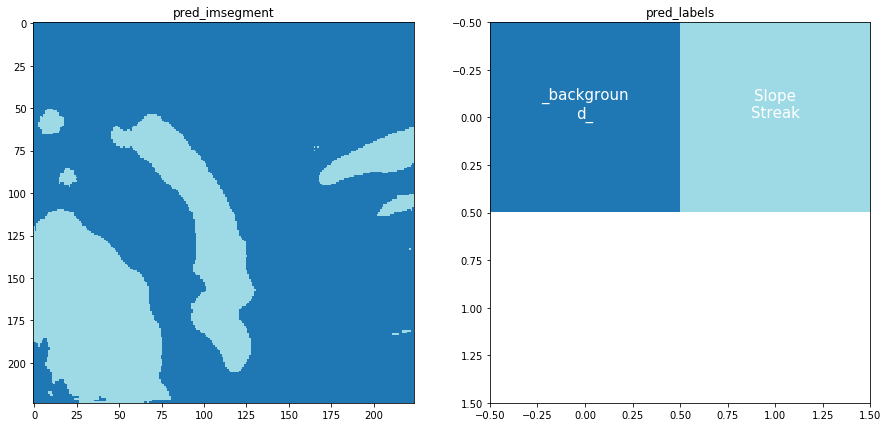

In [0]:
interp.show_xyz(top_idxs[0], sz=15)

# 5. Predictions

In [0]:
learn.pred_batch(data.one_item).shape

torch.Size([32, 8, 224, 224])

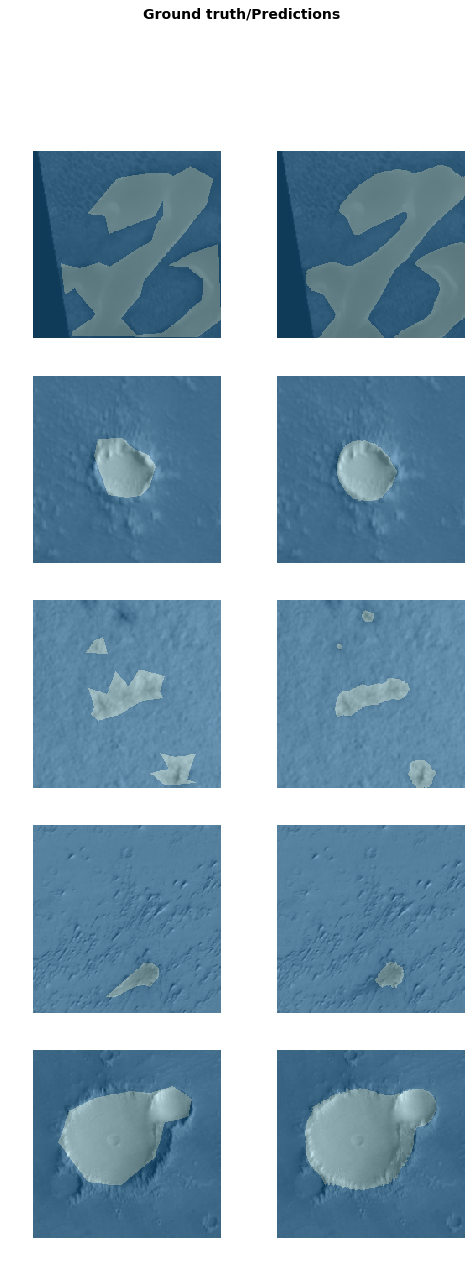

In [0]:
learn.show_results(data.one_item)